In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
N = 10
T = 30
k = 1/180 # w godzinach
h = 1 # w kilometrach
rho_max = 20
v_max = 100
tau = 0.1
chi = 120
c0 = 350
l = 3
m = 1.8    
rho = np.zeros((N+1, T+1))
v = np.zeros((N+1, T+1))

In [40]:
time = np.linspace(0, k*T, T+1)
space = np.linspace(0, h*N, N+1)

In [41]:
# initial
rho[:, 0] = np.round(5 + 3*np.exp((-(space - 7)**2)/5), 2)
v[:, 0] = v_max*(1 - rho[:, 0]/rho_max)


In [42]:
# boundary
rho[0, :] = rho[0, 0]
v[0, :] = v[0, 0]

In [43]:
r = k/h
for t in range(1, T+1):
    for s in range(1, N+1):
        rho[s, t] = rho[s, t-1] + r*(v[s-1, t-1]*rho[s-1, t-1] - v[s, t-1]*rho[s, t-1])
    for s in range(1, N):    
        v[s, t] = v[s, t-1] + k/tau*(v_max*(1 - (rho[s, t-1]/rho_max)**l)**m - v[s, t-1]) + r*v[s, t-1]*(v[s-1, t-1] - v[s, t-1]) - c0*r*(rho[s+1, t-1] - rho[s, t-1])/(chi + rho[s, t-1]) 

In [44]:
x = np.linspace(0, rho_max, 500)
y = v_max*(1 - (x/rho_max)**l)**m - v_max*m*l*((x/rho_max)**l)*(1 - (x/rho_max)**l)**(m-1)

In [45]:
max(abs(y))*k/h

0.760445604841245

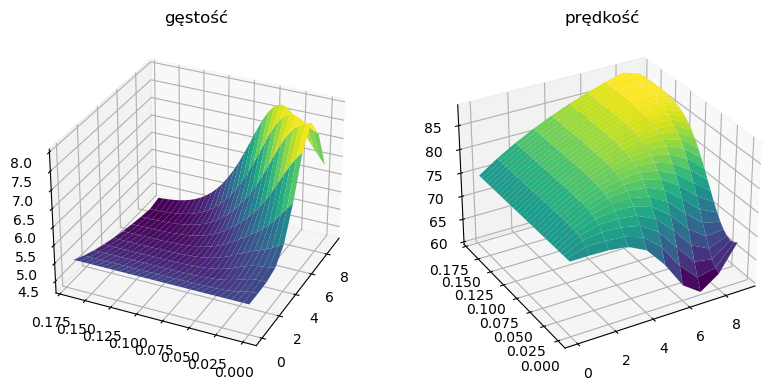

In [46]:
S, T = np.meshgrid(space[0:-1], time)

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(S, T, rho.transpose()[:, 0:-1], cmap='viridis', edgecolor='none')
ax.view_init(elev=30, azim=-155)
ax.set_title('gęstość')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(S, T, v.transpose()[:, 0:-1], cmap='viridis', edgecolor='none')
ax.view_init(elev=30, azim=-120)
ax.set_title('prędkość')

plt.show()

Sprawdzenie czy algorytm dobrze rozwiązuje

- wymyślenie rozwiązania
- dopasowanie równania
- zastosowanie algorytmu do dopasowanego rozwiązania 

$$\rho(x, t) = 20 - \frac{(x - 8)^2}{12} - \frac{(t - 0.15)^2}{0.0016} $$

prędkość taka jak w LWR (więc nie spełnia równania)
$\rho_{max} = 20$, $v_{max} = 100$
$$v(x, t) = v_{max}(1 - \frac{\rho}{\rho_{max}}) = 5\left[\frac{(x - 8)^2}{12} + \frac{(t - 0.15)^2}{0.0016}\right]$$

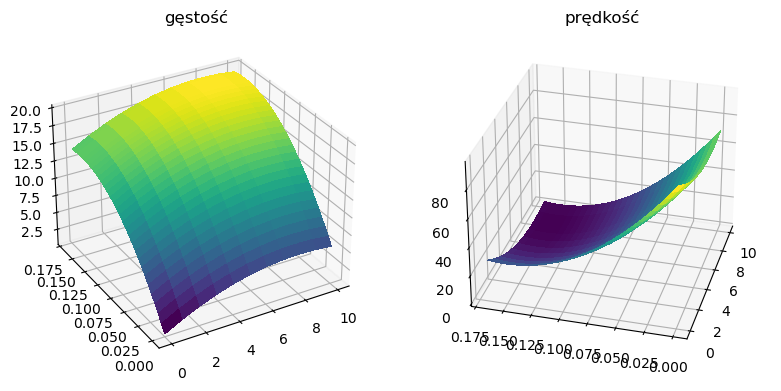

In [ ]:
S, T = np.meshgrid(space, time)
fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')

U = 20 -(S - 8)**2/12 - (T - 0.15)**2/0.0016
V = 100*(1 - U/20)
ax.plot_surface(S, T, U, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0, antialiased=False)
ax.view_init(elev=30, azim=-120)
ax.set_title('gęstość')

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_surface(S, T, V, rstride=1, cstride=1, cmap='viridis',
                       linewidth=0, antialiased=False)
ax.view_init(elev=30, azim=-165)
ax.set_title('prędkość')

plt.show()

In [ ]:
N = 10
T = 30
k = 1/180 # w godzinach
h = 1 # w kilometrach
rho_max = 20
v_max = 100
tau = 0.1
chi = 120
c0 = 350
l = 1
m = 1    
rho = np.zeros((N+1, T+1))
v = np.zeros((N+1, T+1))

In [ ]:
# initial
rho[:, 0] = U[0, :]
v[:, 0] = V[0, :]


In [ ]:
# boundary
rho[0, :] = U[:, 0]
v[0, :] = V[:, 0]

In [ ]:
# FIXME try centered space 
r = k/h
for t in range(1, T+1):
    for s in range(1, N+1):
        x = h*s
        tt = k*(t-1)
        rho[s, t] = rho[s, t-1] + r*(v[s-1, t-1]*rho[s-1, t-1] - v[s, t-1]*rho[s, t-1]) \
            - k*(1250*(tt - 0.15) - 5/3*(x - 8)*((x - 8)**2/12 + 625*(tt - 0.15)**2 - 10))
    for s in range(1, N):
        x = h*s
        tt = k*(t-1)   
        v[s, t] = v[s, t-1] + k/tau*(v_max*(1 - (rho[s, t-1]/rho_max)**l)**m - v[s, t-1]) \
            + r*v[s, t-1]*(v[s-1, t-1] - v[s, t-1]) - c0*r*(rho[s+1, t-1] - rho[s, t-1])/(chi + rho[s, t-1]) \
            + k*(6250*(tt - 0.15) + 25/6*(x - 8)*((x-8)**2/12 + 625*(tt - 0.15)**2) \
            - c0*(x - 8)/(120 - 0.5*(x - 8)**2 - 3750*(tt - 0.15)**2))
             

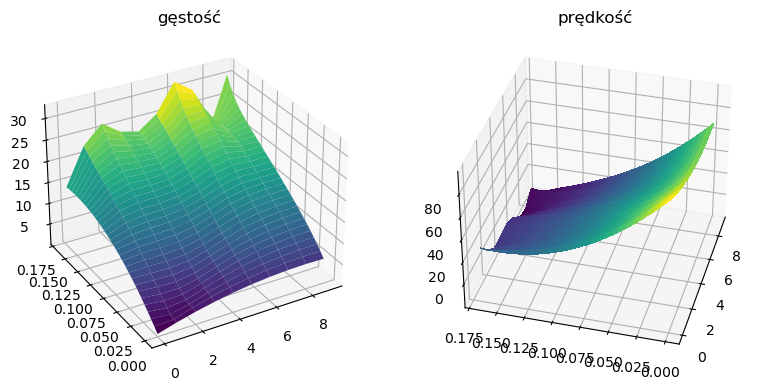

In [ ]:
S2, T2 = np.meshgrid(space[0:-1], time)

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(S2, T2, rho.transpose()[:, 0:-1], cmap='viridis', edgecolor='none')
ax.view_init(elev=30, azim=-120)
ax.set_title('gęstość')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(S2, T2, v.transpose()[:, 0:-1], rstride=1, cstride=1, cmap='viridis',
                       linewidth=0, antialiased=False)
ax.view_init(elev=35, azim=-165)
ax.set_title('prędkość')

plt.show()